# 贝尔不等式

## 贝尔不等式的推导

想象我们进行以下实验。Charlie 准备了两个粒子，他将其中一个粒子发送给 Alice，而把另一个粒子发送给 Bob。  
Alice 一收到粒子就对它进行测量。假设她有两种不同的测量设备，所以她可以选择两种不同的测量方法中的一种。这些测量的物理性质分别标记为$P_Q$和$P_R$。Alice 将在收到粒子后随机选择一种方式进行测量。为了简单起见，我们假设测量结果可以为$+1$或$-1$。假设 Alice 的粒子对性质$P_Q$有一个值$Q$。$Q$被假定为 Alice 粒子的一个仅通过测量来揭示的客观性质。同样，让$R$表示由测量性质$P_R$得到的值。  
类似地，假设Bob能够测量两个属性$P_S$和$P_T$中的一个，分别得到客观存在的属性值$S$和$T$，取值为$+1$或$-1$。Bob在接收到粒子后随机选择一种方式进行测量。实验安排 Alice 和 Bob 同时(或者用相对论的语言描述，是以没有因果联系的方式)进行测量。则由于物理性影响的传播速度不能超过光速， Alice 与 Bob 的测量结果互不干扰。  
对量 $QS+RS+RT-QT=(Q+R)S+(R-Q)T$进行简单的代数运算，可得
$$ QS+RS+RT-QT=(Q+R)S+(R-Q)T $$
因为$R,Q=±1$，所以要么$(Q+R)S = 0$，要么$(R-Q)T =0$。从上式容易看出，对每种情况，有$ QS + RS + RT - QT = ±2 $。下面假设测量前处于状态 $Q = q,R = r,S = s,T = t$ 的概率是 $p(q,r,s,t)$。令$E(·)$表示量的均值，则有
$$ E(QS)+E(RS)+E(RT)-E(QT)=E(QS+RS+RT-QT)=\sum_{qrst}p(q,r,s,t)(qs+rs+rt-qt)\leq\sum_{qrst}p(q,r,s,t) \times 2 = 2$$
由此得到贝尔不等式:
$$ E(QS)+E(RS)+E(RT)-E(QT)\leq 2 $$
通过多次重复实验，Alice 和 Bob 可以确定贝尔不等式左侧的每个量，从而检查它是否在实际实验中成立。

## 量子纠缠对贝尔不等式的违反

现在想象我们进行了下面的量子力学实验，Charlie 准备了一个由两量子比特组成的量子系统，处于状态
$$ | \psi\rangle =cos{\frac{\theta}{2}}|01\rangle + sin{\frac{\theta}{2}}|10\rangle,\quad\theta\in[0,2\pi) $$
他把第一个量子比特传给Alice，第二个量子比特传给Bob。他们进行对如下观测算子的测量:
$$ Q = Z_1,R = X_1 ,S = \frac{-Z_2-X_2}{\sqrt{2}},T = \frac{Z_2-X_2}{\sqrt{2}} $$
其中 $Z=\begin{pmatrix} 1 & 0 \\ 0 & -1\end{pmatrix}$,$X=\begin{pmatrix} 0 & 1 \\ 1 & 0\end{pmatrix}$。  
通过计算可以得到这些观测算子的平均值，写成量子力学$\langle \cdot \rangle$形式是
$$ \langle QS \rangle=\frac{1}{\sqrt{2}},\langle RS \rangle = -\frac{1}{\sqrt{2}}sin\theta,\langle RT\rangle=\frac{1}{\sqrt{2}},\langle QT\rangle=\frac{1}{\sqrt{2}}sin\theta $$
因此，
$$ \langle QS \rangle+\langle RS \rangle+\langle RT \rangle-\langle QT \rangle =\sqrt{2}-\sqrt{2}sin\theta $$
当 $\theta$ 取某些特定的角度时，上式将违反贝尔不等式。下面将用 pyquafu 对此进行演示。

## 创建电路

### 构造量子态

首先我们定义一个函数来构造一个2-量子比特的纠缠态，将量子态从 $|00\rangle$ 变为 $|\psi\rangle =cos{\frac{\theta}{2}}|01\rangle + sin{\frac{\theta}{2}}|10\rangle$，其中 $\theta\in[0,2\pi)$。

In [1]:
from quafu import QuantumCircuit, simulate, Task
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi, cos, sin, sqrt

def create_state(theta = 1.25*pi ):
    """ 构造一个2量子比特的纠缠态
    |00> --> |ψ> = cos(θ/2)|01> + sin(θ/2)|10> θ∈[0,2pi)"""
    qc = QuantumCircuit(2)
    qc.ry(0, theta)
    qc.x(1)
    qc.cnot(0,1)
    return qc

### 转换测量基

测量算子 $S=\frac{-Z-X}{\sqrt{2}}=\begin{pmatrix} -\frac{1}{\sqrt{2}} & -\frac{1}{\sqrt{2}} \\ -\frac{1}{\sqrt{2}} & \frac{1}{\sqrt{2}}\end{pmatrix}$ 的本征值为1的本征态为 $ |v_+\rangle=-\frac{1}{\sqrt{4+2\sqrt{2}}}|0\rangle+\frac{1+\sqrt{2}}{\sqrt{4+2\sqrt{2}}}|1\rangle$，$T=\frac{Z-X}{\sqrt{2}}=\begin{pmatrix} \frac{1}{\sqrt{2}} & -\frac{1}{\sqrt{2}} \\ -\frac{1}{\sqrt{2}} & -\frac{1}{\sqrt{2}}\end{pmatrix}$ 的本征值为1的本征态为 $ |u_+\rangle=-\frac{1+\sqrt{2}}{\sqrt{4+2\sqrt{2}}}|0\rangle+\frac{1}{\sqrt{4+2\sqrt{2}}}|1\rangle$。定义函数旋转测量基，使各个电路可以测得QS、RS、RT、QT的期望。

In [2]:
phi1 = np.arccos(-1/sqrt(4+2*sqrt(2)))  # 用于旋转至S算子本征值1对应的本征态
phi2 = np.arccos(-(1+sqrt(2))/sqrt(4+2*sqrt(2)))  # 用于旋转至T算子本征值1对应的本征态

def QS(theta):
    qc = create_state(theta)
    qc.ry(1,-phi1*2)  # 将第二个量子比特的测量基至S算子本征态
    return qc
def RS(theta):
    qc = create_state(theta)
    qc.ry(0,-pi/2)  # 将第一个量子比特的测量基至X算子本征态
    qc.ry(1,-phi1*2)  # 将第二个量子比特的测量基至S算子本征态
    return qc
def RT(theta):
    qc = create_state(theta)
    qc.ry(0,-pi/2)  # 将第一个量子比特的测量基至X算子本征态
    qc.ry(1,-phi2*2)  # 将第二个量子比特的测量基至T算子本征态
    return qc
def QT(theta):
    qc = create_state(theta)
    qc.ry(1,-phi2*2)  # 将第二个量子比特的测量基至T算子本征态
    return qc
Circuit = [QS,RS,RT,QT]
Circuit_name = ['QS','RS','RT','QT']

### 创建演示任务

然后我们定义用于演示的主函数。它有两个参数，“theta_num”用于确定 $θ$ 值的数量，“experimental”用于选择在真机上运行或用模拟器运行。该函数将在区间 $[0，2\pi)$ 中均匀地获取 `theta_num`个 $θ$  值进行测量，并将相应测量算子的预期 $\langle QS \rangle,\langle RS \rangle,\langle RT \rangle,\langle QT \rangle$ 放在 `obsexp` 中。  
该函数有三个返回参数，`theta`、`obsexp`、`experimental`，分别表示取的 $θ$ 值，对应的四个期望以及它是在真机还是模拟器上运行。此外，如果在真机上运行，该函数将显示任务的历史记录，可以将其保存它以便以后查看。

In [3]:
def Bell_inequality_demo(theta_num = 5, experimental: bool = False):
    theta_step=2*pi/theta_num  
    theta=[]  # 保存θ的值
    obsexp=[]  # 保存 E(QS),E(RS),E(RT),E(QT)
    name=["θ={:.3f}*pi".format(i*theta_step/pi)  for i in range(theta_num)]  # 每个任务的名字
    groupname="Bell_inequality"  # 任务组的名字
    task = Task()  # 创建并配置Task
    shots_num = 2000
    backend = "ScQ-P10"  # ScQ-P10, ScQ-P18, ScQ-P136
    task.config(backend=backend, shots=shots_num, compile=True)
    for i in range(theta_num):
        theta_i = i*theta_step
        sub_obsexp=[] # 保存此次循环中E(QS),E(RS),E(RT),E(QT)的值
        for j in range(4):  # 对四种测量算子对应电路进行遍历
            qc = Circuit[j](theta_i)
            if experimental:
                print("θ={:.3f}*pi, {}, sending task...".format(theta_i/pi,Circuit_name[j]))
                sub_res = task.send(qc, name=','.join([name[i],Circuit_name[j]]), group=groupname)
                sub_obsexp.append(sub_res.calculate_obs([0,1]))
            else:
                simu_res = simulate(qc)
                sub_obsexp.append(simu_res.calculate_obs([0,1]))
        #print('θ={:.3f}*pi, E(QS) ={:.6f}, E(RS) ={:.6f}, E(RT)={:.6f}, E(QT)={:.6f}'.format(theta_i/pi,*sub_obsexp))
        theta.append(theta_i)
        obsexp.append(sub_obsexp)
    if experimental:
        history=task.get_history()
        print(history)  # 保存任务id以便下次查询
    return theta,obsexp,experimental

## 展示运行结果

为了显示理论曲线，我们在区间 $[0,2\pi)$ 内均匀取 100 个 $\theta$ 值并计算$\langle QS \rangle+\langle RS \rangle+\langle RT \rangle-\langle QT \rangle$的理论值$\sqrt{2}-\sqrt{2}sin\theta$。

In [4]:
def Theoretical_value(theta):
    return np.sqrt(2)*(1-sin(theta))  # E(QS)+E(RS)+E(RT)-E(QT)
x = np.linspace(0, 2*pi, 100)
y = Theoretical_value(x)

In [5]:
def Plot_theoretical_value(x,y):
    plt.plot(x, y, label="Theoretical value: sqrt(2)*(1-sin(θ))")
    plt.xlabel("theta")
    plt.ylabel("E(QS)+E(RS)+E(RT)-E(QT)")
    plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.17))

### 在模拟器上运行的结果

通过调用 `uncertainty_principle_demo` 函数并将`experimental`参数设置为 False，我们可以得到在模拟器上运行的结果，然后可以使用 matplotlib 中的方法对其进行可视化。

θ=0.000*pi E(QS)+E(RS)+E(RT)-E(QT)=1.414214
θ=0.250*pi E(QS)+E(RS)+E(RT)-E(QT)=0.414214
θ=0.500*pi E(QS)+E(RS)+E(RT)-E(QT)=-0.000000
θ=0.750*pi E(QS)+E(RS)+E(RT)-E(QT)=0.414214
θ=1.000*pi E(QS)+E(RS)+E(RT)-E(QT)=1.414214
θ=1.250*pi E(QS)+E(RS)+E(RT)-E(QT)=2.414214
θ=1.500*pi E(QS)+E(RS)+E(RT)-E(QT)=2.828427
θ=1.750*pi E(QS)+E(RS)+E(RT)-E(QT)=2.414214


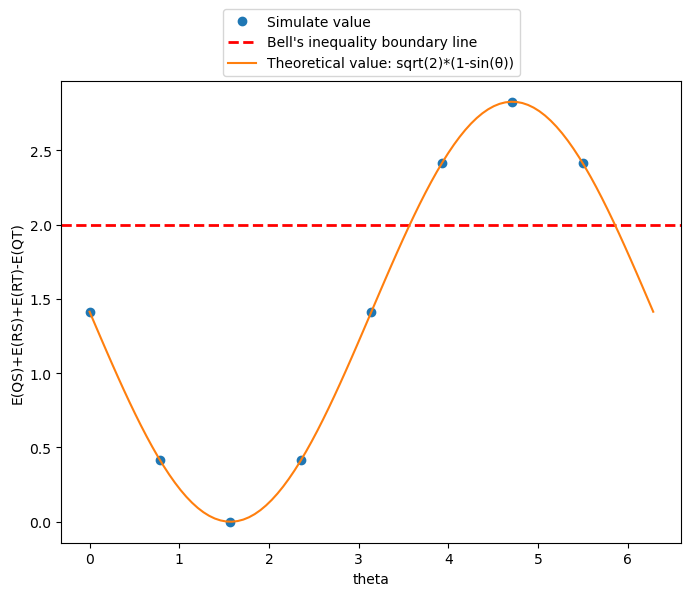

In [6]:
theta, obsexp, experimental = Bell_inequality_demo(theta_num = 8, experimental = False)
res=[obsexp[i][0] + obsexp[i][1] + obsexp[i][2] - obsexp[i][3] for i in range(len(obsexp))]  # E(QS)+E(RS)+E(RT)-E(QT)
for i in range(len(res)):
    print("θ={:.3f}*pi".format(theta[i]/pi),"E(QS)+E(RS)+E(RT)-E(QT)={:.6f}".format(res[i]))  # 展示结果数据
# 展示结果图
plt.figure(figsize=(8, 6)) # 设置图片大小
plt.plot(theta, res, "o", label="Simulate value")
plt.axhline(y=2, color='red', linestyle='--', linewidth=2)  # 画出贝尔不等式的边界线
plt.plot([], [], color='red', linestyle='--', linewidth=2, label='Bell\'s inequality boundary line')  # 为贝尔不等式的边界线增加图例
Plot_theoretical_value(x,y)
plt.show()

### 在真机上运行的结果

将`experimental`参数设置为 True，我们可以得到在真机上运行的结果，同时所运行任务的历史也将显示。

θ=0.000*pi, QS, sending task...
θ=0.000*pi, RS, sending task...
θ=0.000*pi, RT, sending task...
θ=0.000*pi, QT, sending task...
θ=0.250*pi, QS, sending task...
θ=0.250*pi, RS, sending task...
θ=0.250*pi, RT, sending task...
θ=0.250*pi, QT, sending task...
θ=0.500*pi, QS, sending task...
θ=0.500*pi, RS, sending task...
θ=0.500*pi, RT, sending task...
θ=0.500*pi, QT, sending task...
θ=0.750*pi, QS, sending task...
θ=0.750*pi, RS, sending task...
θ=0.750*pi, RT, sending task...
θ=0.750*pi, QT, sending task...
θ=1.000*pi, QS, sending task...
θ=1.000*pi, RS, sending task...
θ=1.000*pi, RT, sending task...
θ=1.000*pi, QT, sending task...
θ=1.250*pi, QS, sending task...
θ=1.250*pi, RS, sending task...
θ=1.250*pi, RT, sending task...
θ=1.250*pi, QT, sending task...
θ=1.500*pi, QS, sending task...
θ=1.500*pi, RS, sending task...
θ=1.500*pi, RT, sending task...
θ=1.500*pi, QT, sending task...
θ=1.750*pi, QS, sending task...
θ=1.750*pi, RS, sending task...
θ=1.750*pi, RT, sending task...
θ=1.750*

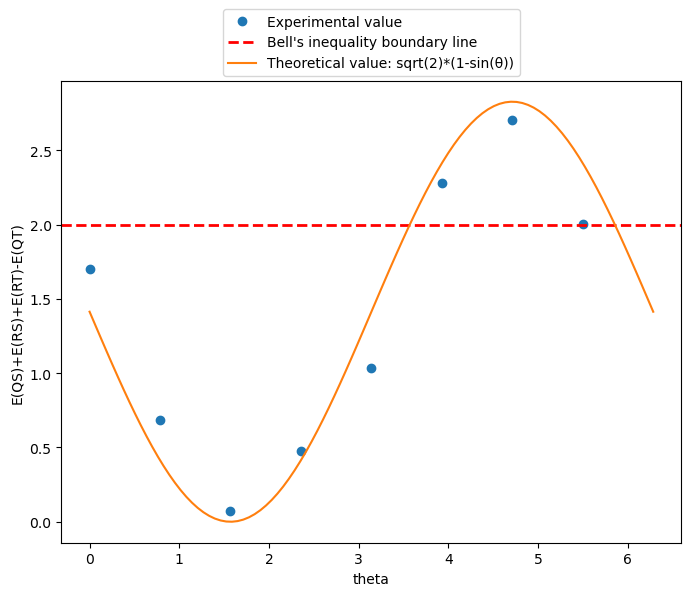

In [7]:
theta, obsexp, experimental = Bell_inequality_demo(theta_num = 8, experimental = True)
res=[obsexp[i][0] + obsexp[i][1] + obsexp[i][2] - obsexp[i][3] for i in range(len(obsexp))]  # E(QS)+E(RS)+E(RT)-E(QT)
for i in range(len(res)):
    print("θ={:.3f}*pi".format(theta[i]/pi),"E(QS)+E(RS)+E(RT)-E(QT)={:.6f}".format(res[i]))  # 展示结果数据
# 展示结果图
plt.figure(figsize=(8, 6)) # 设置图片大小
plt.plot(theta, res, "o", label="Experimental value")
plt.axhline(y=2, color='red', linestyle='--', linewidth=2)  # 画出贝尔不等式的边界线
plt.plot([], [], color='red', linestyle='--', linewidth=2, label='Bell\'s inequality boundary line')  # 为贝尔不等式的边界线增加图例
Plot_theoretical_value(x,y)
plt.show()

### 查看历史记录

如果已保存在真机上运行的任务的id，则可以通过以下方式查看以往的运行结果。

Group:  Bell_inequality
task_id              task_name      status    
280A88203923FD9F     θ=0.000*pi,QS     Completed 
280A88B0153BE9BE     θ=0.000*pi,RS     Completed 
280A893036D8DCED     θ=0.000*pi,RT     Completed 
280A89B010ACC0C8     θ=0.000*pi,QT     Completed 
280A8A2031FA8286     θ=0.250*pi,QS     Completed 
280A8AB018D24B3B     θ=0.250*pi,RS     Completed 
280A8B302F33D4EC     θ=0.250*pi,RT     Completed 
280A8BB014A9E2F3     θ=0.250*pi,QT     Completed 
280A8C2029E7B4F8     θ=0.500*pi,QS     Completed 
280A8CB010D8F918     θ=0.500*pi,RS     Completed 
280A8D3026C8A65F     θ=0.500*pi,RT     Completed 
280A8DC00CD39991     θ=0.500*pi,QT     Completed 
280A8E402196E84F     θ=0.750*pi,QS     Completed 
280A8EC00722F71F     θ=0.750*pi,RS     Completed 
280A8F3028429461     θ=0.750*pi,RT     Completed 
280A8FB0011E5C97     θ=0.750*pi,QT     Completed 
280A902027487907     θ=1.000*pi,QS     Completed 
280A90B001A514DC     θ=1.000*pi,RS     Completed 
280A9130233B16BB     θ=1.000*

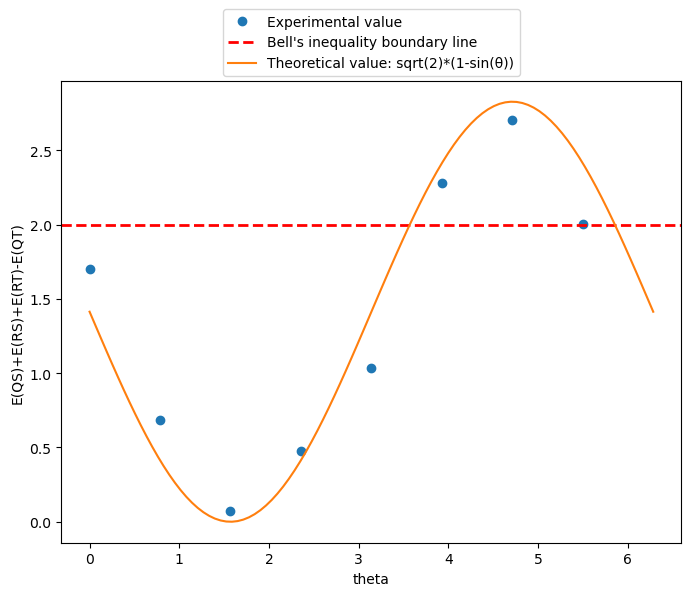

In [8]:
# 将你想要检索的历史复制到old_history中，old_history是字典，其形式为{'group_name': ['taskid']}
old_history={'Bell_inequality': ['280A88203923FD9F', '280A88B0153BE9BE', '280A893036D8DCED', '280A89B010ACC0C8', \
'280A8A2031FA8286', '280A8AB018D24B3B', '280A8B302F33D4EC', '280A8BB014A9E2F3', '280A8C2029E7B4F8', '280A8CB010D8F918', \
'280A8D3026C8A65F', '280A8DC00CD39991', '280A8E402196E84F', '280A8EC00722F71F', '280A8F3028429461', '280A8FB0011E5C97', \
'280A902027487907', '280A90B001A514DC', '280A9130233B16BB', '280A91A0379318B9', '280A923020357FA6', '280A92B0379975A3', \
'280A93301C97DEB5', '280A93B002E54984', '280A942017E01F20', '280A94A03A07CDF1', '280A9530134C1427', '280A95A03531A52C', \
'280A96300FD5F099', '280A96B032D16A2A', '280A974018DA84B0', '280A97B02DA6DFD5']}
newtask = Task()
result = newtask.retrieve_group("Bell_inequality", history=old_history)
obsexp=[]
for i in range(len(result)):
    if i % 4 == 0:
        obsexp.append([])
    obsexp[-1].append(result[i].calculate_obs([0,1]))
theta = [ i*2*pi/len(obsexp) for i in range(len(obsexp)) ]
res=[obsexp[i][0] + obsexp[i][1] + obsexp[i][2] - obsexp[i][3] for i in range(len(obsexp))]  # E(QS)+E(RS)+E(RT)-E(QT)
for i in range(len(res)):
    print("θ={:.3f}*pi".format(theta[i]/pi),"E(QS)+E(RS)+E(RT)-E(QT)={:.6f}".format(res[i]))  # 展示结果数据
# 展示结果图
plt.figure(figsize=(8, 6)) # 设置图片大小
plt.plot(theta, res, "o", label="Experimental value")
plt.axhline(y=2, color='red', linestyle='--', linewidth=2)  # 画出贝尔不等式的边界线
plt.plot([], [], color='red', linestyle='--', linewidth=2, label='Bell\'s inequality boundary line')  # 为贝尔不等式的边界线增加图例
Plot_theoretical_value(x,y)
plt.show()